In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from datetime import  timedelta
from sklearn.metrics import silhouette_score

# Reading the transaction dataset and transformation

In [2]:
df_org  = pd.read_csv('C:/Users/sepid/Desktop/H & m/transactions_train.csv',
                        usecols= ['t_dat', 'customer_id', 'article_id'], 
                        dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'}) 
df_org['t_dat'] = pd.to_datetime(df_org['t_dat'])

In [3]:
# there are no null values
df_org.isna().sum()

t_dat          0
customer_id    0
article_id     0
dtype: int64

in the first part, there is no customer clustering and its recommendation solely on popularity of products.

# weekly popularity qoutient

For popularity, I calculated the weekly purchase amount of every article then divided each to the last week purchse amount. (if no purchase then its 0). then summing them all for each product and we can consider this as a raw rank and based on that we choose 12 best rank.

In [9]:
# Create a copy of the original DataFrame to perform transformations on
df = df_org.copy()

# Transformation: Convert hexadecimal customer IDs to int64
df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

# Find the maximum purchase date in the dataset which is 2020-09-22 and it is Tuesday
last_ts = df['t_dat'].max()

# Calculate weekly counts of purchases starting from every Tuesday to the next Tuesday
# Create a temporary DataFrame to store the date and its day of the week
tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek

# Calculate the last Tuesday's date for each purchase date
# for example if it is Thursday it will return 2 days before and if it is Monday it will return date of tomorrow
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

#calculating the next Tuesday 
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

# Add the 'ldbw' column to df
df['ldbw'] = tmp['ldbw'].values

## Count the number of purchases for each product and week (grouping products with lbdw)
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

# Merge the weekly sales counts back into the main DataFrame
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
# Reset and set the index for 'article_id' for later use
weekly_sales = weekly_sales.reset_index().set_index('article_id')

# Count the amount of last week's purchases for each product   
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))

# Fill missing values with 0 for products that had no purchases in the last week
df['count_targ'].fillna(0, inplace=True)
del weekly_sales

# Calculate the quotient for each product, which is the last week's purchases divided by each week's purchases
df['quotient'] = df['count_targ'] / df['count']

# Sum all quotients for each product to create a target sales score
target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()

# Find the top 12 products with the highest target sales scores for recommendation
general_pred = target_sales.nlargest(12).index.tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)

# Read the submission file and concatenate the predicted products for each customer
sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                    usecols= ['customer_id'], 
                    dtype={'customer_id': 'string'})
sub['prediction'] = general_pred_str
sub = sub[['customer_id', 'prediction']]
sub.to_csv('C:/Users/sepid/Desktop/H & m/submission_.csv',index=False)
# this has public score of 0.00508 and private score of 0.00559

# weighted weekly popularity 

From previous popularity, each article, can have different quotient scores based on having different amount of purchase in different weeks.
In this section I considered a weight given to each row of purchase based on the date of the transaction. So the older the purchase is, the smaller the weight it becomes. this weight will be multiplied by quotient and creating new score. then for every customer and every article this new score will be summed up and 12 highest score will be kept and recommended to the customer. if the customer has less than 12 historical purchase, then to fill 12 articles, the rest will be recommended from general recommendation.

<function matplotlib.pyplot.show(close=None, block=None)>

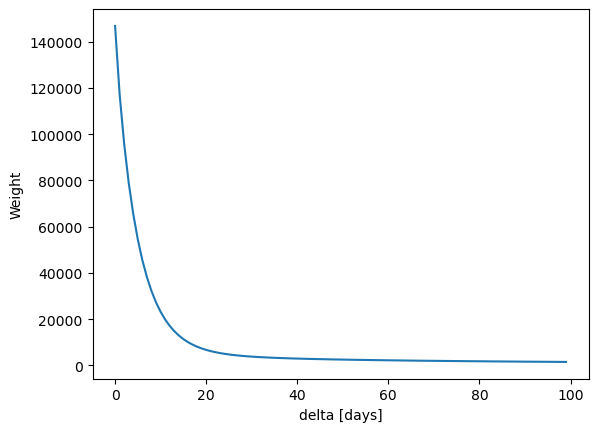

In [26]:
# a weightning function is created like the plot below
a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
x = np.array(range(0, 100))
y = a / np.sqrt((x+1)) + b * np.exp(-c * (x+1)) - d
plt.plot(x, y)
plt.xlabel("delta [days]")
plt.ylabel("Weight")
plt.show

In [8]:
# Create a copy of the original DataFrame to perform transformations on
df = df_org.copy()

# Transformation: Convert hexadecimal customer IDs to int64
df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

# Find the maximum purchase date in the dataset which is 2020-09-22 and it is Tuesday
last_ts = df['t_dat'].max()

# Calculate weekly counts of purchases starting from every Tuesday to the next Tuesday
# Create a temporary DataFrame to store the date and its day of the week
tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek

# Calculate the last Tuesday's date for each purchase date
# for example if it is Thursday it will return 2 days before and if it is Monday it will return date of tomorrow
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

# calculating the next Tuesday
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

# Add the 'ldbw' column to df
df['ldbw'] = tmp['ldbw'].values

## Count the number of purchases for each product and week (grouping products with lbdw)
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

# Merge the weekly sales counts back into the main DataFrame
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
# Reset and set the index for 'article_id' for later use
weekly_sales = weekly_sales.reset_index().set_index('article_id')

# Count the amount of last week's purchases for each product   
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))

# Fill missing values with 0 for products that had no purchases in the last week
df['count_targ'].fillna(0, inplace=True)
del weekly_sales

# Calculate the quotient for each product, which is the last week's purchases divided by each week's purchases
df['quotient'] = df['count_targ'] / df['count']

# Sum all quotients for each product to create a target sales score
target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()

# Find the top 12 products with the highest target sales scores for recommendation
general_pred = target_sales.nlargest(12).index.tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)

del target_sales
# Perform additional calculations based on time intervals

tmp = df.copy()
# Calculate the days difference between the last date and the purchase date
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)

# If it's the last date of purchase, substitute 0 for 'x' with 1
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

# Calculate a weight ('y') based on the time difference ('x')
tmp['y'] = a / np.sqrt((tmp['x']+1)) + b * np.exp(-c*(tmp['x']+1)) - d

# Substitute negative weights with 0
tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)

# Multiply weights by quotients and creating new score "value" then aggregate it for each customer and article
tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

# Rank the values and select the top 12 recommendations for each customer
tmp = tmp.loc[tmp['value'] > 0]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

# Sort values for each customer and create a string of article_ids and keep it in prediction
purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()
purchase_df = pd.DataFrame(purchase_df)

# Read the submission file
sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                    usecols= ['customer_id'], 
                    dtype={'customer_id': 'string'})
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
           suffixes = ('', '_ignored'))

# Customers with no purchase history will be recommended with the general prediction (top 12 quotients)
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

# For customers with existing purchase history, if their number of predictions is less than 12,
# the rest will be filled with general predictions
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
sub['prediction'] = sub['prediction'].str.strip()
sub['prediction'] = sub['prediction'].str[:131]
sub = sub[['customer_id', 'prediction']]
sub.to_csv('C:/Users/sepid/Desktop/H & m/submission_.csv',index=False)
# this has public score of 0.02232 and private score of 0.02249

,t_dat,customer_id,article_id,ldbw,count,count_targ,quotient,x,dummy_1,y,dummy_0,value
0,2018-09-20,-2680555179758308952,377277001,2018-09-25,25,1,0.04,733,1,0.000000,0,0.000000
1,2018-09-20,-2680555179758308952,377277001,2018-09-25,25,1,0.04,733,1,0.000000,0,0.000000
2,2018-09-21,9142220995662993228,377277001,2018-09-25,25,1,0.04,732,1,0.000000,0,0.000000
3,2018-09-21,-768637430091632237,377277001,2018-09-25,25,1,0.04,732,1,0.000000,0,0.000000
4,2018-09-23,7630809113904913554,377277001,2018-09-25,25,1,0.04,730,1,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
12541131,2020-09-22,5442673980601289540,860135008,2020-09-22,1,1,1.00,1,1,117225.676435,0,117225.676435
12541132,2020-09-22,5442673980601289540,539060028,2020-09-22,2,2,1.00,1,1,117225.676435,0,117225.676435
12541133,2020-09-22,5442673980601289540,539060028,2020-09-22,2,2,1.00,1,1,117225.676435,0,117225.676435
12541134,2020-09-22,-6999381269962475342,810737015,2020-09-22,1,1,1.00,1,1,117225.676435,0,117225.676435


# popularity only with 2 last weeks quotient

In this section I examined how the score will be changed if instead of last week I choose the last two weeks for quotient division.
(the rest of the code going to be unchanged)

In [12]:
# Create a copy of the original DataFrame to perform transformations on
df = df_org.copy()

# Transformation: Convert hexadecimal customer IDs to int64
df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

# Find the maximum purchase date in the dataset which is 2020-09-22 and it is Tuesday
last_ts = df['t_dat'].max()

#calculating also the tuesday before the last tuesday
notLast_ts = last_ts - timedelta(days=7)

# Calculate weekly counts of purchases starting from every Tuesday to the next Tuesday
# Create a temporary DataFrame to store the date and its day of the week
tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek

# Calculate the last Tuesday's date for each purchase date
# for example if it is Thursday it will return 2 days before and if it is Monday it will return date of tomorrow
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

# calculating the next Tuesday
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

# Add the 'ldbw' column to df
df['ldbw'] = tmp['ldbw'].values

## Count the number of purchases for each product and week (grouping products with lbdw)
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

# Merge the weekly sales counts back into the main DataFrame
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
# Reset and set the index for 'article_id' for later use
weekly_sales = weekly_sales.reset_index().set_index('article_id')

# Count the amount of last week's purchases for each product   
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==notLast_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))

# Fill missing values with 0 for products that had no purchases in the last week
df['count_targ'].fillna(0, inplace=True)
del weekly_sales

# Calculate the quotient for each product, which is the last week's purchases divided by each week's purchases
df['quotient'] = df['count_targ'] / df['count']

# Sum all quotients for each product to create a target sales score
target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()

# Find the top 12 products with the highest target sales scores for recommendation
general_pred = target_sales.nlargest(12).index.tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)

del target_sales
# Perform additional calculations based on time intervals

tmp = df.copy()
# Calculate the days difference between the last date and the purchase date
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)

# If it's the last date of purchase, substitute 0 for 'x' with 1
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

# Calculate a weight ('y') based on the time difference ('x')
tmp['y'] = a / np.sqrt((tmp['x']+1)) + b * np.exp(-c*(tmp['x']+1)) - d

# Substitute negative weights with 0
tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)

# Multiply weights by quotients and creating new score "value" then aggregate it for each customer and article
tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

# Rank the values and select the top 12 recommendations for each customer
tmp = tmp.loc[tmp['value'] > 0]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

# Sort values for each customer and create a string of article_ids and keep it in prediction
purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()
purchase_df = pd.DataFrame(purchase_df)

# Read the submission file
sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                    usecols= ['customer_id'], 
                    dtype={'customer_id': 'string'})
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
           suffixes = ('', '_ignored'))

# Customers with no purchase history will be recommended with the general prediction (top 12 quotients)
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

# For customers with existing purchase history, if their number of predictions is less than 12,
# the rest will be filled with general predictions
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
sub['prediction'] = sub['prediction'].str.strip()
sub['prediction'] = sub['prediction'].str[:131]
sub = sub[['customer_id', 'prediction']]
sub.to_csv('C:/Users/sepid/Desktop/H & m/submission_.csv',index=False)
# this has public score of 0.02228 and private score of 0.02221

,t_dat,customer_id,article_id,ldbw,count,count_targ1,count_targ2,count_targ,quotient
0,2018-09-20,-232048505547517783,573937001,2018-09-25,213,7,3,10,0.046948
1,2018-09-20,27523763215971119,573937001,2018-09-25,213,7,3,10,0.046948
2,2018-09-20,6291940812455747255,573937001,2018-09-25,213,7,3,10,0.046948
3,2018-09-20,8198980377844517220,573937001,2018-09-25,213,7,3,10,0.046948
4,2018-09-20,8198980377844517220,573937001,2018-09-25,213,7,3,10,0.046948
...,...,...,...,...,...,...,...,...,...
11068946,2020-09-17,5771585948373285519,881049001,2020-09-22,6,6,1,7,1.166667
11068947,2020-09-17,-8696939418798805323,881049001,2020-09-22,6,6,1,7,1.166667
11068948,2020-09-18,3899568626620664025,881049001,2020-09-22,6,6,1,7,1.166667
11068949,2020-09-20,9195727427654827124,881049001,2020-09-22,6,6,1,7,1.166667


# removing transactions in 2018

comparing 2 previous popularities,  last week quotinet had better output and it is going to be used for rest of the work.  in this section, I removed 2018 transaction to see how the score changes

In [12]:
df_org1 = df_org[df_org['t_dat']>='2019-01-01'] 

In [5]:
df = df_org1.copy()
# Transformation: Convert hexadecimal customer IDs to int64
df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

# Find the maximum purchase date in the dataset which is 2020-09-22 and it is Tuesday
last_ts = df['t_dat'].max()

# Calculate weekly counts of purchases starting from every Tuesday to the next Tuesday
# Create a temporary DataFrame to store the date and its day of the week
tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek

# Calculate the last Tuesday's date for each purchase date
# for example if it is Thursday it will return 2 days before and if it is Monday it will return date of tomorrow
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

# calculating the next Tuesday
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

# Add the 'ldbw' column to df
df['ldbw'] = tmp['ldbw'].values

## Count the number of purchases for each product and week (grouping products with lbdw)
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

# Merge the weekly sales counts back into the main DataFrame
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
# Reset and set the index for 'article_id' for later use
weekly_sales = weekly_sales.reset_index().set_index('article_id')

# Count the amount of last week's purchases for each product   
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))

# Fill missing values with 0 for products that had no purchases in the last week
df['count_targ'].fillna(0, inplace=True)
del weekly_sales

# Calculate the quotient for each product, which is the last week's purchases divided by each week's purchases
df['quotient'] = df['count_targ'] / df['count']

# Sum all quotients for each product to create a target sales score
target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()

# Find the top 12 products with the highest target sales scores for recommendation
general_pred = target_sales.nlargest(12).index.tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)

del target_sales
# Perform additional calculations based on time intervals

tmp = df.copy()
# Calculate the days difference between the last date and the purchase date
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)

# If it's the last date of purchase, substitute 0 for 'x' with 1
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

# Calculate a weight ('y') based on the time difference ('x')
tmp['y'] = a / np.sqrt((tmp['x']+1)) + b * np.exp(-c*(tmp['x']+1)) - d

# Substitute negative weights with 0
tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)

# Multiply weights by quotients and creating new score "value" then aggregate it for each customer and article
tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

# Rank the values and select the top 12 recommendations for each customer
tmp = tmp.loc[tmp['value'] > 0]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

# Sort values for each customer and create a string of article_ids and keep it in prediction
purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()
purchase_df = pd.DataFrame(purchase_df)

# Read the submission file
sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                    usecols= ['customer_id'], 
                    dtype={'customer_id': 'string'})
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
           suffixes = ('', '_ignored'))

# Customers with no purchase history will be recommended with the general prediction (top 12 quotients)
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

# For customers with existing purchase history, if their number of predictions is less than 12,
# the rest will be filled with general predictions
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
sub['prediction'] = sub['prediction'].str.strip()
sub['prediction'] = sub['prediction'].str[:131]
sub = sub[['customer_id', 'prediction']]
sub.to_csv('C:/Users/sepid/Desktop/H & m/submission_.csv',index=False)
# this has public score of 0.02235 and private score of 0.0225

now that we have found our best popularity method we can use it to combine with with clustering method

# Reading Customer dataset and transformation

In [13]:
customers  = pd.read_csv('C:/Users/sepid/Desktop/H & m/customers.csv')

In [14]:
# postal code is not really bringing any information about the location of the customer so it can be removed
customers = customers.drop(['postal_code'], axis=1)

In [5]:
customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
dtype: int64

In [6]:
customers['age'].unique()

array([49., 25., 24., 54., 52., nan, 20., 32., 29., 31., 56., 75., 41.,
       27., 30., 48., 35., 22., 40., 38., 45., 68., 55., 19., 60., 44.,
       21., 26., 28., 53., 33., 17., 23., 51., 18., 34., 57., 47., 70.,
       50., 63., 58., 43., 67., 72., 42., 39., 79., 71., 59., 36., 62.,
       37., 46., 73., 64., 74., 61., 85., 69., 76., 66., 65., 82., 16.,
       90., 80., 78., 81., 84., 77., 97., 89., 83., 98., 88., 86., 87.,
       93., 91., 99., 96., 94., 92., 95.])

C:\Users\sepid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

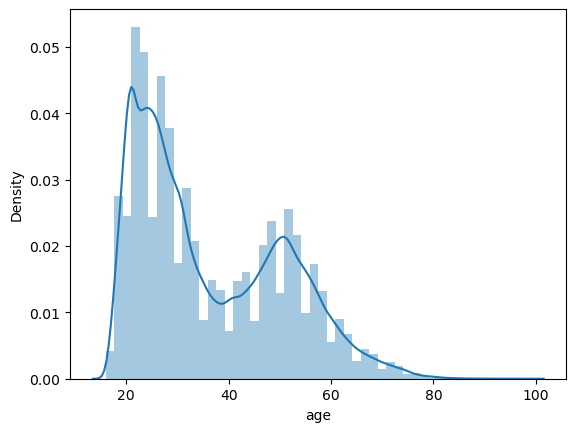

In [8]:
sns.distplot(customers['age'])

from the histogram of age we can see that distribution is not symmetric so choosing mean to fill NAs is not the best option. for skewed distribution is better to choose mode or median and i preferred to go with mode.

In [15]:
customers['age'].fillna(int((customers['age'].mode())), inplace=True)

In [9]:
customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)

In [61]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

in fashion news none has been mentioned 2 times with lower and upper case so it can be considered both 1 thing also it
better to change all string data to digits for easier further work.NA values are filled with None as it is the most
mentioned value

In [16]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({np.nan :0,'NONE':0, 'None':0, 'Monthly':1, 'Regularly':2})

In [11]:
customers['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [17]:
customers['club_member_status'] = customers['club_member_status'].replace({np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':3})

# clustering the customers

In the first clustering experienceI used all columns to create customer cluster with kmeans.

In [13]:
usecol = ['club_member_status', 'fashion_news_frequency', 'age', 'FN', 'Active']
predcol = ['customer_id']

In [18]:
scores = []
def clustering(df, predcol, usecol, clusters=12):

    X = np.array(df[usecol])

#norming numbers
    nm = preprocessing.StandardScaler()
    X = nm.fit_transform(X)

#km = KMeans(n_clusters=clusters, random_state=2022)
    km = KMeans(n_clusters=clusters, 
                init='k-means++', 
                random_state=2022)
    km.fit(X)
    distortion = km.inertia_

    pred = km.labels_
    df_pred = pd.DataFrame(pred, columns=['pred'])
    df_pred = pd.concat([df, df_pred], axis=1)

    df_norm = pd.DataFrame(X, columns=usecol)
    #print(df_norm.describe())
    
    return df_pred, distortion

In [25]:
distortions = []
kx = []
for k in range(2,12):
    print(f'---- K = {k} ----')
    dfCustomers, dist = clustering(customers, predcol=predcol, usecol=usecol, clusters=k)
    distortions.append(dist)
    kx.append(k)

---- K = 2 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 3 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 4 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 5 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 6 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 7 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 8 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 9 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 10 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 11 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<function matplotlib.pyplot.show(close=None, block=None)>

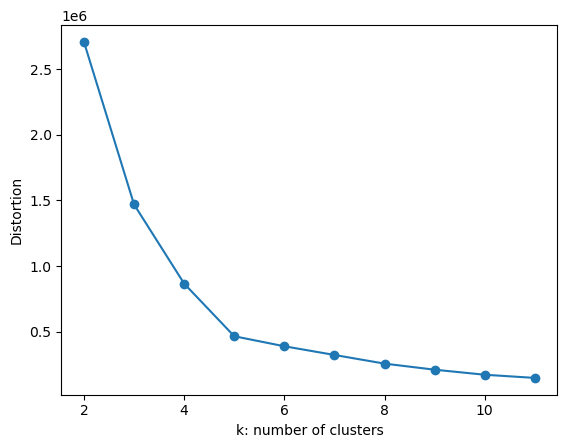

In [26]:
plt.plot(kx, distortions)
plt.scatter(kx, distortions)
plt.xlabel("k: number of clusters")
plt.ylabel("Distortion")
plt.show

based on the elbow graph, the best number for clusters would be 5

In [15]:
dfCustomers, dist = clustering(customers,predcol=predcol, usecol=usecol, clusters=5)

C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sepid\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sepid\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [37]:
dfCustomers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,pred
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,2,0,49.0,4
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,2,0,25.0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,2,0,24.0,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,2,0,54.0,4
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,2,2,52.0,0
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,2,0,24.0,1
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,2,0,21.0,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,2,2,21.0,3
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,2,2,18.0,3


In [16]:
listUniBins = dfCustomers['pred'].unique()

C:\Users\sepid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pred', ylabel='Density'>

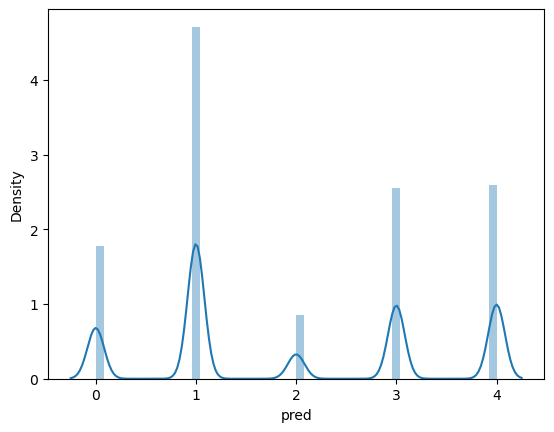

In [18]:
sns.distplot(dfCustomers['pred'])

In [19]:
dist

574640.1093258426

In [32]:
dfCustomers[dfCustomers['pred']==0]['age'].describe()

count    516693.000000
mean         26.282173
std           5.399404
min          16.000000
25%          22.000000
50%          26.000000
75%          30.000000
max          39.000000
Name: age, dtype: float64

# recommendation based on clusters 

popularity that 2018 dataset was removed had highest score so it is chosen as the base to combine it with clustering. in this part, the whole popularity is being done seperately for each customer cluster. In this way, articles have different quotient score in different customer clusters. we can consider it more customized version of recommendation.

In [20]:
for uniBin in listUniBins: 
    
    df = df_org1.copy()
    dfCustomersTemp = dfCustomers[dfCustomers['pred'] == uniBin]
    dfCustomersTemp = dfCustomersTemp.drop(['pred'], axis=1)
    
    #
    # Transformation: Convert hexadecimal customer IDs to int64
    df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

    # Find the maximum purchase date in the dataset which is 2020-09-22 and it is Tuesday
    last_ts = df['t_dat'].max()

    # Calculate weekly counts of purchases starting from every Tuesday to the next Tuesday
    # Create a temporary DataFrame to store the date and its day of the week
    tmp = df[['t_dat']].copy()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek

    # Calculate the last Tuesday's date for each purchase date
    # for example if it is Thursday it will return 2 days before and if it is Monday it will return date of tomorrow
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

    # calculating the next Tuesday
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    # Add the 'ldbw' column to df
    df['ldbw'] = tmp['ldbw'].values

    ## Count the number of purchases for each product and week (grouping products with lbdw)
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

    # Merge the weekly sales counts back into the main DataFrame
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    # Reset and set the index for 'article_id' for later use
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    # Count the amount of last week's purchases for each product   
    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    # Fill missing values with 0 for products that had no purchases in the last week
    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales

    # Calculate the quotient for each product, which is the last week's purchases divided by each week's purchases
    df['quotient'] = df['count_targ'] / df['count']

    # Sum all quotients for each product to create a target sales score
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()

    # Find the top 12 products with the highest target sales scores for recommendation
    general_pred = target_sales.nlargest(12).index.tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)

    del target_sales
    # Perform additional calculations based on time intervals

    tmp = df.copy()
    # Calculate the days difference between the last date and the purchase date
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)

    # If it's the last date of purchase, substitute 0 for 'x' with 1
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    # Calculate a weight ('y') based on the time difference ('x')
    tmp['y'] = a / np.sqrt((tmp['x']+1)) + b * np.exp(-c*(tmp['x']+1)) - d

    # Substitute negative weights with 0
    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)

    # Multiply weights by quotients and creating new score "value" then aggregate it for each customer and article
    tmp['value'] = tmp['quotient'] * tmp['y'] 
    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    # Rank the values and select the top 12 recommendations for each customer
    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    # Sort values for each customer and create a string of article_ids and keep it in prediction
    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = pd.DataFrame(purchase_df)

    # Read the submission file
    sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                        usecols= ['customer_id'], 
                        dtype={'customer_id': 'string'})
    sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))

    # Customers with no purchase history will be recommended with the general prediction (top 12 quotients)
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)

    # For customers with existing purchase history, if their number of predictions is less than 12,
    # the rest will be filled with general predictions
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'C:/Users/sepid/Desktop/H & m/unibins/submission_' + str(uniBin) + '.csv',index=False)

for i, uniBin in enumerate(listUniBins):
    dfTemp  = pd.read_csv(f'C:/Users/sepid/Desktop/H & m/unibins/submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = pd.concat([dfSub, dfTemp], axis=0)
dfSub.to_csv(f'C:/Users/sepid/Desktop/H & m/submission_.csv', index=False)
# this has public score of 0.02245 and private score of 0.02256

The shape of scope transaction for 4 is (4986418, 4). 

The shape of scope transaction for 1 is (10123659, 4). 

The shape of scope transaction for 0 is (4567098, 4). 

The shape of scope transaction for 2 is (528800, 4). 

The shape of scope transaction for 3 is (7171087, 4). 



after doing the same procedure but for whole dataset including 2018 teh score results are:
public score of 0.02242 and private score of 0.02255

with slice difference clusters works better with dataset that 2018 is cut off from

now in clustering step, instead of all columns I am going to use only age, fashion frequency newas and club member status and remove FN and Active as they do not seem very informative.

In [19]:
usecol = ['club_member_status', 'fashion_news_frequency', 'age']
predcol = ['customer_id']

In [20]:
dfCustomers, dist = clustering(customers,predcol=predcol, usecol=usecol, clusters=5)

C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sepid\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sepid\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [21]:
dist

465029.34825960983

In [23]:
listUniBins = dfCustomers['pred'].unique()

comparing elbow scores, new dist has decreased to 465029.34825960983 from 574640.1093258426 which shows better clustering than previous one.

In [24]:
for uniBin in listUniBins: 
    
    df = df_org1.copy()
    dfCustomersTemp = dfCustomers[dfCustomers['pred'] == uniBin]
    dfCustomersTemp = dfCustomersTemp.drop(['pred'], axis=1)
    
    #
    df = df.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')

    # transformation part
    df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    # here we get the maximum date of purchase we have which is 2020-09-22 and it is Tuesday
    last_ts = df['t_dat'].max()
    # as the last date is Tuesday so weekly count of purchases are going to be counted from every Tuesday to the next Tuesday
    # for doing so first we nee dto have all dates and their day of week
    tmp = df[['t_dat']].copy()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    #in this part every t-dat is taken and find the Tuesday related to the week of that t-dat and saves it in lbdw
    # for example if date is Thursday it will return date of 2 days ago which is Tuesday and if it is Monday it will return date of tomorrow
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    #next step is calculating next Tuesday after the one in lbdw
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')
    df['ldbw'] = tmp['ldbw'].values
    #so basically here we count purchase of articles for each week (grouping products with lbdw)
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    weekly_sales = weekly_sales.reset_index().set_index('article_id')
    #count_targ is amount of last week purchase of each product    
    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))
    # in case of no last week purchase of that product it will be filled with 0
    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    # based on last week purchase a quotient is calculated which is divisison of amouunt of last week purchase over each week
    df['quotient'] = df['count_targ'] / df['count']
    # then all quotients are summed for each article individually
    # thisn qoutient can be used as a baseline also
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    # this target sales is each product score and based on that the top 12 can be recommended to the customers with no purchase history
    general_pred = target_sales.nlargest(12).index.tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    purchase_dict = {}
    tmp = df.copy()
    # here days difference between last date and purchase date of each transiction is calculated
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    # if it it the last date purchase then we substitude 0 x with 1
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)
    #by using this function, transaction dates closer to last week are given more importance
    tmp['y'] = a / np.sqrt((tmp['x']+1)) + b * np.exp(-c*(tmp['x']+1)) - d
    # substitution of negative weights by 0
    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    # wight are multiplied by qoutients and then aggregated for each customer and article
    tmp['value'] = tmp['quotient'] * tmp['y'] 
    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()
    # we rank the value and then 12 highest ranks for each customer
    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]
    # values are sorted for each customer
    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = pd.DataFrame(purchase_df)
    # we read the sub file and to each customer we contacenate its related predictions
    sub  = pd.read_csv('C:/Users/sepid/Desktop/H & m/sample_submission.csv',
                        usecols= ['customer_id'], 
                        dtype={'customer_id': 'string'})
    sub = sub.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))
    # customers with no history will be recommended with general prediction which is top 12 quotinet
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    # and here for customers that they already have purchase history if their number of predictions is less than 12 the rest will be filled with general prediction
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'C:/Users/sepid/Desktop/H & m/unibins/submission_' + str(uniBin) + '.csv',index=False)

for i, uniBin in enumerate(listUniBins):
    dfTemp  = pd.read_csv(f'C:/Users/sepid/Desktop/H & m/unibins/submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = pd.concat([dfSub, dfTemp], axis=0)
dfSub.to_csv(f'C:/Users/sepid/Desktop/H & m/submission_.csv', index=False)
# this has public score of 0.02246 and private score of 0.02257

The shape of scope transaction for 3 is (4978006, 4). 

The shape of scope transaction for 0 is (10100461, 4). 

The shape of scope transaction for 4 is (4552147, 4). 

The shape of scope transaction for 2 is (565598, 4). 

The shape of scope transaction for 1 is (7180850, 4). 



Text(0.5, 0, 'club_member_status')

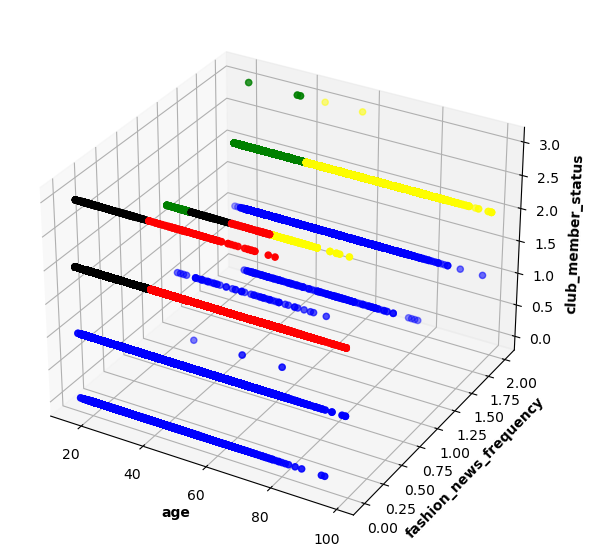

In [26]:
df0=dfCustomers[dfCustomers.pred==0]
df1=dfCustomers[dfCustomers.pred==1]
df2=dfCustomers[dfCustomers.pred==2]
df3=dfCustomers[dfCustomers.pred==3]
df4=dfCustomers[dfCustomers.pred==4]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(df1["age"],df1["fashion_news_frequency"],df1["club_member_status"],color='green')
ax.scatter3D(df2["age"],df2["fashion_news_frequency"],df2["club_member_status"],color='blue')
ax.scatter3D(df3["age"],df3["fashion_news_frequency"],df3["club_member_status"],color='red')
ax.scatter3D(df4["age"],df4["fashion_news_frequency"],df4["club_member_status"],color='yellow')
ax.scatter3D(df0["age"],df0["fashion_news_frequency"],df0["club_member_status"],color='black')

ax.set_xlabel('age', fontweight ='bold')
ax.set_ylabel('fashion_news_frequency', fontweight ='bold')
ax.set_zlabel('club_member_status', fontweight ='bold')

C:\Users\sepid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pred', ylabel='Density'>

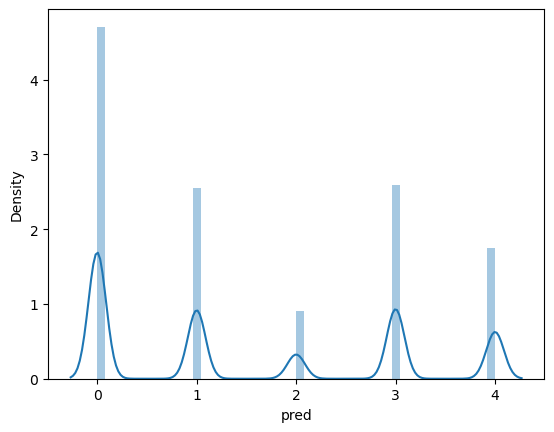

In [27]:
sns.distplot(dfCustomers['pred'])

# Age grouping

here I clustered our customers only with age. instead of kmean I used simple age grouping.

In [29]:
customers['age'].min()

16.0

In [30]:
customers['age'].max()

99.0

lets create 3 age groups: from 16 to 30 as first age group then from 30 to 50 the second age groupand from 50 to 99 as the last group

In [34]:
customers['group'] = customers['age'].apply(lambda x : 1 if x<30 else(2 if 30 <= x < 50 else 3))

In [35]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,2,0,49.0,2
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,2,0,25.0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,2,0,24.0,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,2,0,54.0,3
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,2,2,52.0,3
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,2,0,24.0,1
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,2,0,21.0,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,2,2,21.0,1
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,2,2,18.0,1


In [37]:
dfCustomers = customers.drop(['FN' , 'Active' , 'club_member_status' , 'fashion_news_frequency' , 'age'] , axis=1)

In [44]:
listUniBins = customers['group'].unique()

doing the whole previous steps on age groups on dataset where 2018 is removed we get score:
public score of 0.02267 and private score of 0.02264

so far this is the best result

now lets change the age grouping and instead of 3 make 4 age groups. from 16 to 25, 25 to 35, 35 to 55 and the rest going to be in the same category

In [49]:
customers = customers.drop(['group'],axis=1)

In [51]:
customers['group'] = customers['age'].apply(lambda x : 1 if x<25 else(2 if 25 <= x < 35 else (3 if 35 <= x < 55 else 4)))

In [63]:
dfCustomers = customers.drop(['FN' , 'Active' , 'club_member_status' , 'fashion_news_frequency' , 'age'] , axis=1)

In [64]:
listUniBins = dfCustomers['group'].unique()

changing age groups from 3 to 4 decreased the scores:
this has public score of 0.02256 and private score of 0.02262
so 3 age group was better option

# clustering with age group

based on teh result the first grouping was better. now I am going to do clustering on first age grouping combined by other columns

In [78]:
customers['group'] = customers['age'].apply(lambda x : 1 if x<30 else(2 if 30 <= x < 50 else 3))

In [79]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,2,0,49.0,2
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,2,0,25.0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,2,0,24.0,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,2,0,54.0,3
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,2,2,52.0,3
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,2,0,24.0,1
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,2,0,21.0,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,2,2,21.0,1
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,2,2,18.0,1


In [80]:
usecol = ['club_member_status', 'fashion_news_frequency', 'group']
predcol = ['customer_id']

In [81]:
distortions = []
kx = []
for k in range(2,12):
    print(f'---- K = {k} ----')
    dfCustomers, dist = clustering(customers, predcol=predcol, usecol=usecol, clusters=k)
    distortions.append(dist)
    kx.append(k)

---- K = 2 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 3 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 4 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 5 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 6 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 7 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 8 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 9 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 10 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


---- K = 11 ----


C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<function matplotlib.pyplot.show(close=None, block=None)>

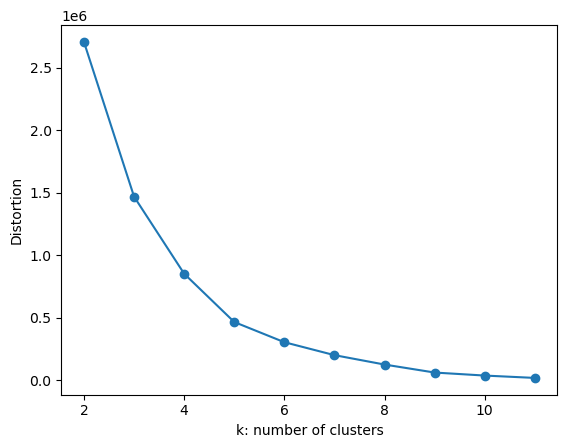

In [82]:
plt.plot(kx, distortions)
plt.scatter(kx, distortions)
plt.xlabel("k: number of clusters")
plt.ylabel("Distortion")
plt.show

In [84]:
dfCustomers, dist = clustering(customers,predcol=predcol, usecol=usecol, clusters=6)

C:\Users\sepid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [87]:
listUniBins = dfCustomers['pred'].unique()

the result is:
this has public score of 0.0225 and private score of 0.02253

it works the best when we consider the age only